In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4.

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=1.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e-1
    
    return loss_temp

def claps_loss(x):
    z_d_gen=backend.batch_flatten(x)          
    nom = tf.matmul(z_d_gen, tf.transpose(z_d_gen, perm=[1, 0]))
    denom = tf.sqrt(tf.reduce_sum(tf.square(z_d_gen), reduction_indices=[1], keep_dims=True))
    pt = tf.square(tf.transpose((nom / denom), (1, 0)) / denom)
    pt = pt - tf.diag(tf.diag_part(pt))
    pulling_term = tf.reduce_sum(pt) / (mb_size * (mb_size - 1))*50
    
    return pulling_term

def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/8, hight/8, 1]), 
                                                  deconv2_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/8, hight/8, deconv2_1_features]),deconv2_1_bias))

    h2_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_1,deconv2_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, hight/4, deconv2_2_features]),deconv2_2_bias))    
    
    h3_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_2, deconv3_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, hight/4, deconv3_1_features]),deconv3_1_bias))

    h3_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_1, deconv3_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, deconv3_2_features]),deconv3_2_bias))
    
    h4_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_2, deconv4_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, deconv4_1_features]),deconv4_1_bias))

    h4_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h4_1, deconv4_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, deconv4_2_features]),deconv4_2_bias))    
    
    h5 = (tf.add(tf.nn.conv2d_transpose(h4_2, deconv5_weight, strides=[1, 1, 1, 1], padding='SAME',
                                        output_shape=[mb_size, width/1, hight/1, 1]),deconv5_bias))
    
    prob = tf.nn.sigmoid(h5)
    return prob


def Q(X):
    h1_1 = tf.nn.relu(tf.add(conv2d(tf.reshape(X,[mb_size, width/1, height/1, 1]),
                                  conv1_1_weight, stride=1, padding='SAME'),conv1_1_bias))
    
    h1_2 = tf.nn.relu(tf.add(conv2d(h1_1,conv1_2_weight, stride=2, padding='SAME'),conv1_2_bias))
    
    h2_1 = tf.nn.relu(tf.add(conv2d(h1_2,conv2_1_weight, stride=1, padding='SAME'),conv2_1_bias))
    
    h2_2 = tf.nn.relu(tf.add(conv2d(h2_1,conv2_2_weight, stride=2, padding='SAME'),conv2_2_bias))

    h3_1 = tf.nn.relu(tf.add(conv2d(h2_2,conv3_1_weight, stride=1, padding='SAME'),conv3_1_bias))
    
    h3_2 = tf.nn.relu(tf.add(conv2d(h3_1,conv3_2_weight, stride=2, padding='SAME'),conv3_2_bias))    
    
    h4 = tf.nn.relu(tf.matmul(tf.reshape(h3_2,[mb_size,width/8*height/8*conv3_2_features]), Q_W1) + Q_b1)
    
    z_mu = tf.matmul(h4, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h4, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

In [2]:
######## loading input data ########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import h5py
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


images = np.array(sio.loadmat('alloy_mat/X_train.mat')['X_train'],dtype='float32')
images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')
images=images[0:10000]

mb_size = 100
X_dim = images.shape[1]
width = 40
height = 40
hight = 40
h_dim = width/8*height/8
z_dim = 40/8


conv1_1_features=32
conv1_2_features=32
conv2_1_features=32*2
conv2_2_features=32*2
conv3_1_features=32*3
conv3_2_features=32*3
conv4_features=1
c = 0

deconv2_1_features=32*3
deconv2_2_features=32*3
deconv3_1_features=32*2
deconv3_2_features=32*2
deconv4_1_features=32
deconv4_2_features=32
lr = 1e-3


# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([len(images),height,width,3])
style_array[:,:,:,0]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,1]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,2]=(images.reshape(len(images),height,width))*1
print(style_array.shape)


Using TensorFlow backend.


(10000, 40, 40, 3)


In [3]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [4]:
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, 1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

conv1_1_weight = tf.Variable(tf.truncated_normal([4, 4, 1, conv1_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_1_bias = tf.Variable(tf.zeros([conv1_1_features], dtype=tf.float32))

conv1_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_1_features, conv1_2_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_2_bias = tf.Variable(tf.zeros([conv1_2_features], dtype=tf.float32))

conv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_2_features,conv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_1_bias = tf.Variable(tf.zeros([conv2_1_features], dtype=tf.float32))

conv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_1_features,conv2_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv2_2_bias = tf.Variable(tf.zeros([conv2_2_features], dtype=tf.float32))

conv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_2_features,conv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv3_1_bias = tf.Variable(tf.zeros([conv3_1_features], dtype=tf.float32))

conv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_1_features,conv3_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv3_2_bias = tf.Variable(tf.zeros([conv3_2_features], dtype=tf.float32))



Q_W1 = tf.Variable(xavier_init([X_dim/8/8*conv3_2_features, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [5]:
# =============================== P(X|z) ======================================
P_W1 = tf.Variable(xavier_init([z_dim, h_dim]),name="P_W1")
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]),name="P_b1")

deconv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_1_features, 1],
                                               stddev=0.1, dtype=tf.float32))
deconv2_1_bias = tf.Variable(tf.zeros([deconv2_1_features], dtype=tf.float32))

deconv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_2_features,deconv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv2_2_bias = tf.Variable(tf.zeros([deconv2_2_features], dtype=tf.float32))

deconv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_1_features, deconv2_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_1_bias = tf.Variable(tf.zeros([deconv3_1_features], dtype=tf.float32))

deconv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_2_features, deconv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_2_bias = tf.Variable(tf.zeros([deconv3_2_features], dtype=tf.float32))

deconv4_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_1_features, deconv3_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_1_bias = tf.Variable(tf.zeros([deconv4_1_features], dtype=tf.float32))

deconv4_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_2_features, deconv4_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_2_bias = tf.Variable(tf.zeros([deconv4_2_features], dtype=tf.float32))

deconv5_weight = tf.Variable(tf.truncated_normal([4, 4, 1, deconv4_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv5_bias = tf.Variable(tf.zeros([1], dtype=tf.float32))



In [6]:
# =============================== Middel Results ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)


In [7]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*1
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [8]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [9]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [75]:
C10=sess.run(conv_out4,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              style_image: style_array_input.reshape(mb_size,40,40,3),
                                                              z: np.random.randn(mb_size, z_dim)})
# C10_g=sess.run(gram_matrix(C10[0,:,:,:]))
# C10_g.shape

In [77]:
pulling_term

0.50543344

In [76]:
z_d_gen_test=(sess.run(backend.batch_flatten((C10))))
nom=sess.run(tf.matmul(z_d_gen_test, tf.transpose(z_d_gen_test, perm=[1, 0])))
denom = sess.run(tf.sqrt(tf.reduce_sum(tf.square(z_d_gen_test), reduction_indices=[1], keep_dims=True)))
pt = sess.run(tf.square(tf.transpose((nom / denom), (1, 0)) / denom))
pt = pt - sess.run(tf.diag(tf.diag_part(pt)))
pulling_term = sess.run(tf.reduce_sum(pt) / (mb_size * (mb_size - 1)))

In [16]:
# =============================== latent to Young's Module ====================================
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with linear activation
    out_layer = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([z_dim, z_dim/4])),
    'h2': tf.Variable(tf.random_normal([z_dim/4, 1])),
}

biases = {
    'b1': tf.Variable(tf.random_normal([z_dim/4])),
    'b2': tf.Variable(tf.random_normal([1])),
}

label = tf.placeholder(tf.float32, shape=[None, 1])
pred = multilayer_perceptron(z_sample, weights, biases)

In [10]:
# =============================== Cost ====================================

# Style transfer
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out1_S,conv_out1)
sl4 = style_loss(conv_out3_S,conv_out3)
sl = sl1 + sl2 + sl3 + sl4


# # claps cost
cl1 = claps_loss(conv_out2)
cl2 = claps_loss(conv_out4)
cl3 = claps_loss(conv_out1)
cl4 = claps_loss(conv_out3)
cl = cl1+cl2+cl3+cl4

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/1
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + sl + cl)
vae_loss2= tf.reduce_mean(recon_loss + kl_loss + cl)

In [11]:
import random
solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()
cl_E_store=[]
for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E,sl_E,sl_E1,sl_E2,sl_E3,sl_E4 = sess.run([solver, vae_loss, recon_loss, kl_loss, cl, sl, sl1, sl2, sl3, sl4], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                                              style_image: style_array_input.reshape(mb_size,40,40,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    
#     cl_E_store.append(cl_E)
    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
        print('sl_E1:{}'.format(sl_E1))
        print('sl_E2:{}'.format(sl_E2))
        print('sl_E3:{}'.format(sl_E3))
        print('sl_E4:{}'.format(sl_E4))
#         print('cl_E:{}'.format(cl_E))
        
        print()


Iter: 0
Loss: 9595.91503906
recon_E:721.316162109
kl_E:8637.58496094
cl_E:180.533050537
sl_E:56.480556488
sl_E1:1.57116925716
sl_E2:20.1709384918
sl_E3:0.063754171133
sl_E4:34.6746940613
()
Iter: 200
Loss: 283.886199951
recon_E:142.364700317
kl_E:14.966881752
cl_E:97.2450027466
sl_E:29.3096027374
sl_E1:1.52921581268
sl_E2:7.08110666275
sl_E3:0.150138810277
sl_E4:20.5491409302
()
Iter: 400
Loss: 255.070510864
recon_E:114.373176575
kl_E:15.7693576813
cl_E:93.7896881104
sl_E:31.1382884979
sl_E1:0.84098303318
sl_E2:11.0134506226
sl_E3:0.042828373611
sl_E4:19.2410259247
()
Iter: 600
Loss: 224.11239624
recon_E:95.848739624
kl_E:16.223323822
cl_E:92.1643295288
sl_E:19.876001358
sl_E1:0.657035529613
sl_E2:7.61761856079
sl_E3:0.031821321696
sl_E4:11.5695257187
()
Iter: 800
Loss: 220.724975586
recon_E:89.3507003784
kl_E:16.829044342
cl_E:90.6617355347
sl_E:23.8834991455
sl_E1:2.47800397873
sl_E2:7.26888895035
sl_E3:0.192714735866
sl_E4:13.9438905716
()
Iter: 1000
Loss: 212.728302002
recon_E:83.0

KeyboardInterrupt: 

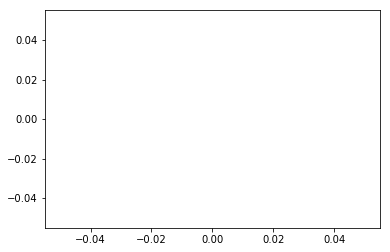

In [18]:
plt.plot(cl_E_store)

In [12]:
save_path = saver.save(sess, "/tmp/model_tinghao_deeper.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model_tinghao_deeper.ckpt")

for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E,sl_E,sl_E1,sl_E2,sl_E3,sl_E4 = sess.run([solver, vae_loss, recon_loss, kl_loss, cl, sl, sl1, sl2, sl3, sl4], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                                              style_image: style_array_input.reshape(mb_size,40,40,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    
#     cl_E_store.append(cl_E)
    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
        print('sl_E1:{}'.format(sl_E1))
        print('sl_E2:{}'.format(sl_E2))
        print('sl_E3:{}'.format(sl_E3))
        print('sl_E4:{}'.format(sl_E4))
#         print('cl_E:{}'.format(cl_E))
        
        print()

Iter: 0
Loss: 136.841766357
recon_E:22.1977806091
kl_E:17.7613639832
cl_E:85.0676879883
sl_E:11.8149299622
sl_E1:1.84727227688
sl_E2:3.5729637146
sl_E3:0.122244559228
sl_E4:6.27244901657
()


KeyboardInterrupt: 

In [82]:
style_array_input = style_array[0:20]*1.0
_, S2, S4, S7, S10 = sess.run([solver, conv_out2_S,conv_out4_S,conv_out7_S,conv_out10_S], 
                                                feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                          label:Y_L.reshape(mb_size,1),
                                                          style_image: style_array_input.reshape(mb_size,128,128,3),
                                                          z: np.random.randn(mb_size, z_dim)})

In [84]:
S2.shape

(20, 64, 64, 64)

In [119]:
S2_1=sess.run(gram_matrix(S2[1,:,:,:]))
S2_2=sess.run(gram_matrix(S2[2,:,:,:]))
# (4. * (channels ** 2) * (size ** 2))
np.sum(np.square(S2_1-S2_2))/(4. * (3 ** 2) * (128 ** 4))*1e-7

18.417130666666665

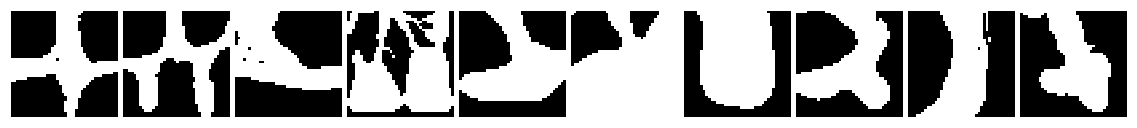

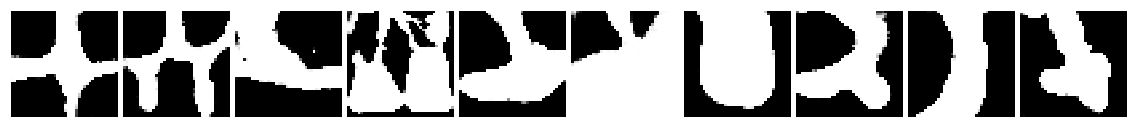

In [15]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(40, 40), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})

plot(images[0:10])
plot(recon[0:10])

In [39]:
X_mb = images[0:100]
latent_z = sess.run(z_sample,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                   z:latent_z})
# plt.hist(latent_z.reshape(-1))

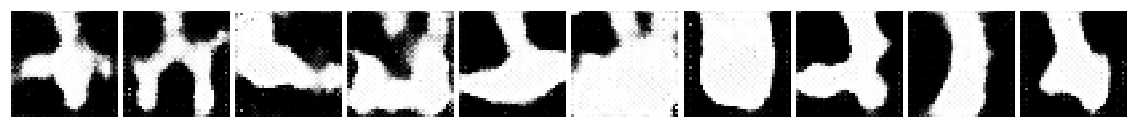

In [40]:
plot(recon[0:10])

In [65]:
latent_z[0]

array([ 1.711236  , -0.04596984,  4.25061083, -1.91780806, -0.11361575,
        2.67244267,  1.5135622 ,  0.27514249,  3.52868009,  0.80107349], dtype=float32)

In [80]:
z_test=np.random.normal(0, 1, [mb_size, z_dim])
z_test.

array([ 1.24151147, -0.10461167, -0.88397652, -0.31908458, -1.60733783,
       -0.73418617, -0.03694799,  1.12246131,  0.07111627, -0.32261865])

(array([   1.,    1.,   14.,   53.,  249.,  290.,  183.,   93.,   86.,   30.]),
 array([-5.95920992, -4.83351364, -3.70781736, -2.58212109, -1.45642481,
        -0.33072853,  0.79496775,  1.92066402,  3.0463603 ,  4.17205658,
         5.29775286]),
 <a list of 10 Patch objects>)

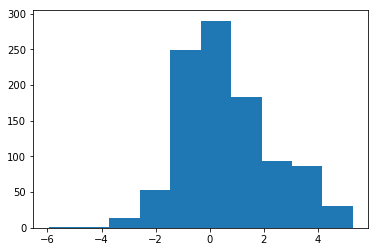

In [62]:
plt.hist(latent_z.reshape(-1))

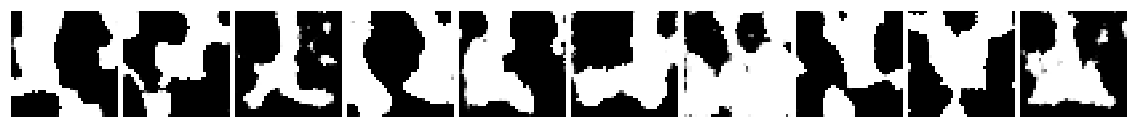

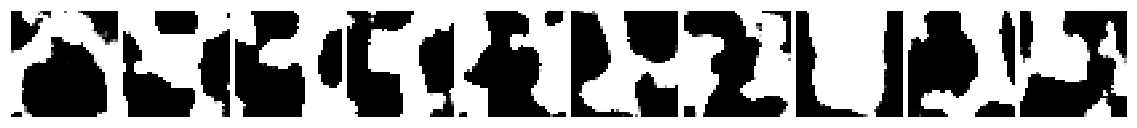

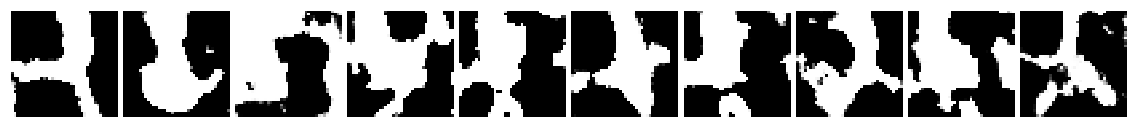

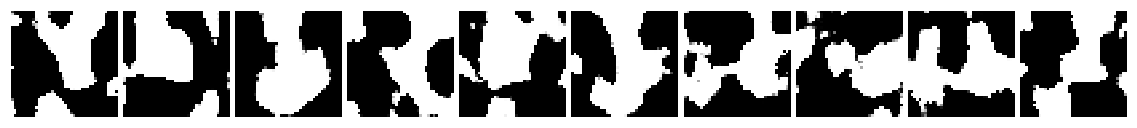

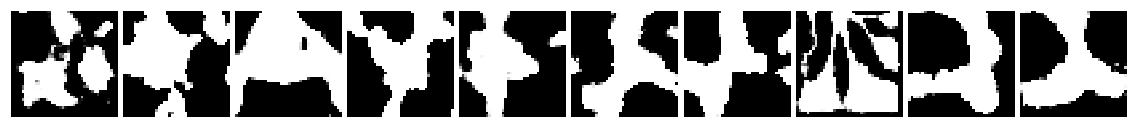

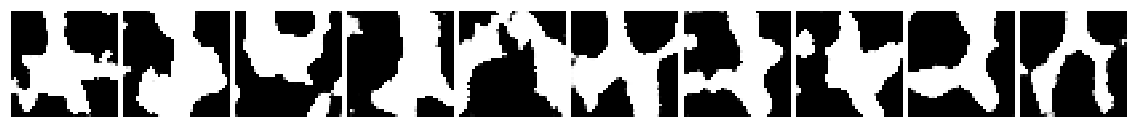

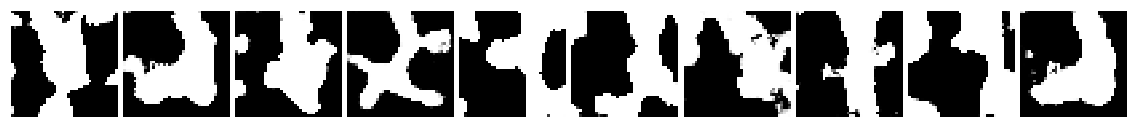

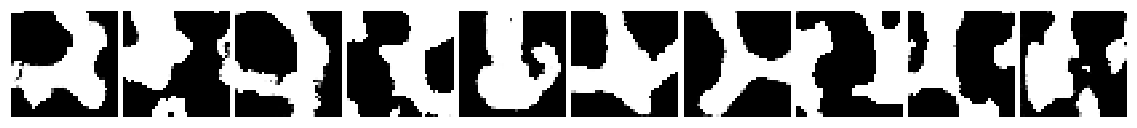

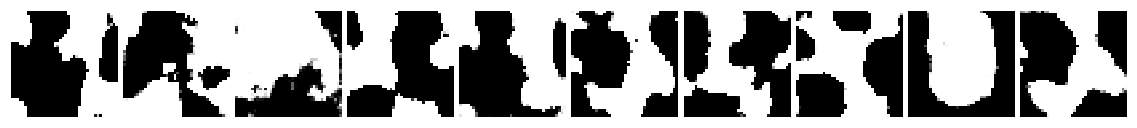

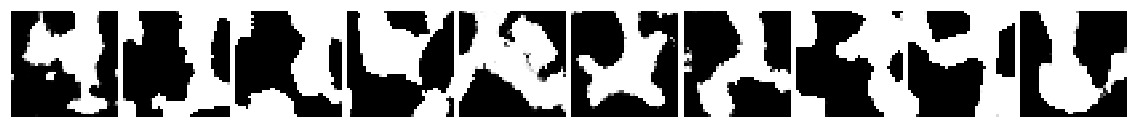

In [16]:
samples = sess.run(X_samples, feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                         z: np.random.normal(0, 1, [mb_size, z_dim])})
for i in range(10):
    plot(samples[i*10:i*10+10])

[[ -1.97246493e+00   3.00514191e-01   3.11042767e-01   2.16765273e-02
    4.17486062e-01   2.36834877e-01   2.75403634e-02   1.09782667e+00
    1.47443693e+00   7.04673276e-01]
 [  7.01897219e-01  -1.11161739e+00   8.93531908e-01   4.11116975e-01
    9.99656298e-01  -9.54821113e-01   1.06968014e+00   1.19741702e+00
   -6.04692815e-01   7.95241722e-01]
 [ -1.45386152e+00  -4.89522318e-01  -4.45874023e-01  -1.56917671e+00
    7.00750976e-01  -2.06053852e-02  -9.46487940e-02   5.47429734e-01
    5.65091593e-01   3.73194758e-01]
 [ -1.65774167e+00  -4.76316824e-01   3.48204167e-02   1.53625137e+00
   -1.36108387e-01  -2.48548435e-01  -6.48891340e-02   5.81601933e-02
   -1.21378439e+00  -1.30311771e+00]
 [  3.94301682e-01  -1.73988380e-01   1.12474798e+00   1.19906523e+00
   -3.02779581e-01   6.42362816e-01  -1.81994960e+00  -1.09460597e-01
    5.30183208e-01   7.22193311e-01]
 [ -2.07848733e+00   1.64031293e-01   3.52429792e-01   1.19429871e+00
    4.92003247e-01  -1.50829082e-01  -1.27075

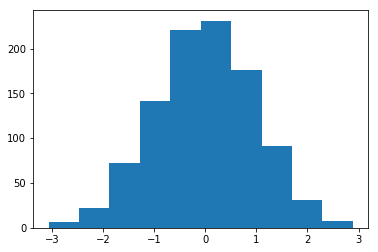

In [31]:
z_test = np.random.normal(0, 1, [mb_size, z_dim])
plt.hist(z_test.reshape(-1))
print(z_test)

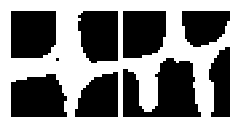

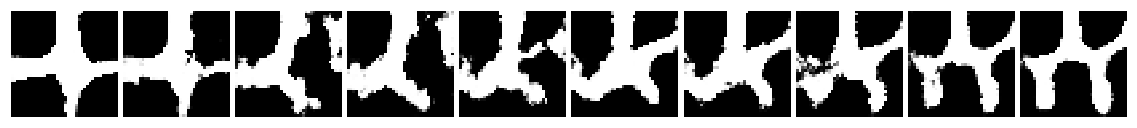

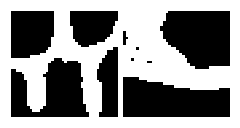

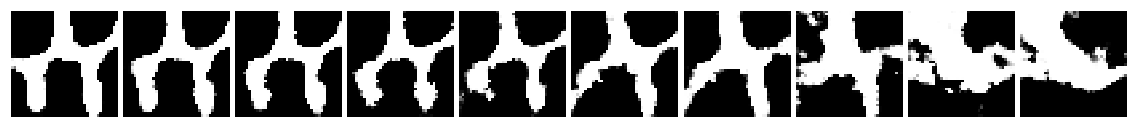

In [17]:
X_mb = images[0:100]
xtr=np.zeros([mb_size*4,width,height,1])
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})


step=(z_temp[1]-z_temp[0])/10
z_grad=np.zeros([10,5])
for i in range(10):
    z_grad[i,:]=z_temp[0]+step*i

z_temp[0:10,:]=z_grad
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
plot(images[0:2])
plot(sample_temp[0:10]);

X_mb = images[0:100]
xtr=np.zeros([mb_size*4,width,height,1])
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})

step=(z_temp[2]-z_temp[1])/10
z_grad=np.zeros([10,5])
for i in range(10):
    z_grad[i,:]=z_temp[1]+step*i

z_temp[0:10,:]=z_grad
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
plot(images[1:3])
plot(sample_temp[0:10]);

In [24]:
z_temp.shape

(100, 5)

In [39]:
X_mb = images_diff[0:mb_size]
# recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                  label:Y_L.reshape(mb_size,1)})

xtr=np.zeros([mb_size*10,width,height,num_channels_1])
k=0
for i in range(10):  
    z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, num_channels_1)})
    
    rand_index=random.sample(np.arange(32),32)
    z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()    
    
    sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
    xtr[k*mb_size:k*mb_size+mb_size,:,:,:]=sample_temp
    k=k+1
    
plot(X_mb[0:10])
plot(xtr[0:10])
plot(xtr[20:30])
plot(xtr[40:50])
plot(xtr[60:70])
plot(xtr[80:90])
plot(xtr[100:110])
plot(xtr[120:130])
plot(xtr[140:150])
plot(xtr[160:170])

NameError: name 'images_diff' is not defined

In [108]:
xtr.shape

(200, 128, 128, 1)

In [103]:
sample_temp.shape

(20, 128, 128, 1)

In [73]:
import random
# noise=np.zeros([20,32])
# np.random.permutation(16)
rand_index=random.sample(np.arange(32),8)
z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()

In [102]:
random.random()

0.661602944971148

In [61]:
np.arange(10).tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]